In [2]:



from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
import ssapp.Utils as Utils
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_formats = ['png']
%load_ext autoreload
%autoreload 2

from torch.utils.data.dataloader import DataLoader

from ssapp.data.AntennaDatasetLoaders import load_serialized_dataset
from ssapp.models.NeuralNetworkModels.Autoencoders import PatchAntenna1ConvAutoEncoder
from ssapp.models.HelperFunctions import loadModel
from ssapp.Utils import FigureSaver

figSaver = FigureSaver('Latent Space Plots',default_format='png')


dataset = load_serialized_dataset('CircularHornDataset1')




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


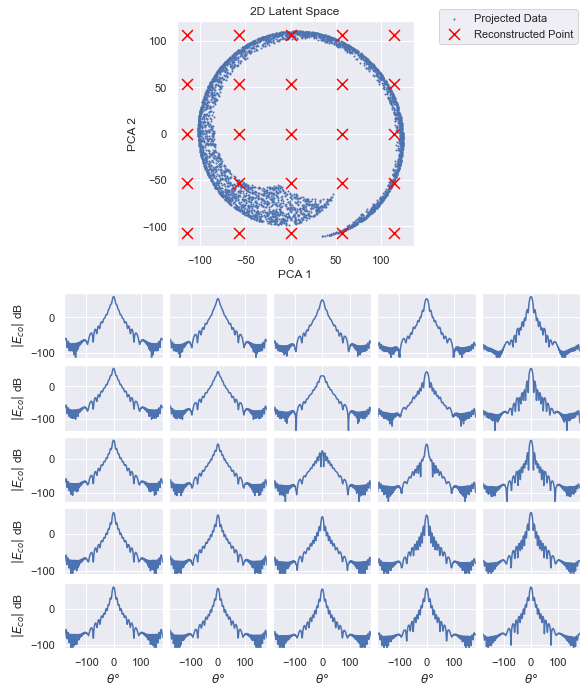

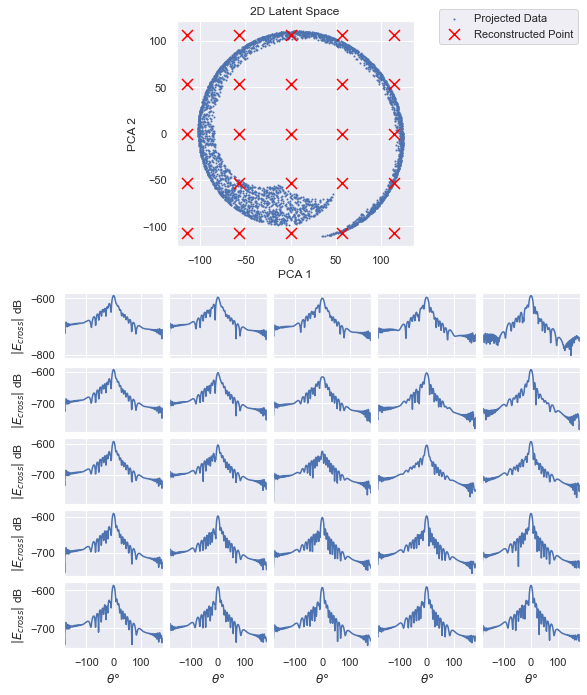

In [6]:
from ssapp.visualization import PCA_Visualisation

from ssapp.visualization.PCA_Visualisation import plotInverseTransformStandardPCA


plotInverseTransformStandardPCA(dataset,component='co',pca_components = [1,2],phi_cut = [0], num_std_dev=1.5,num_cols=5,num_rows=5)
figSaver.save('CircularHornLatentSpace_co')
plotInverseTransformStandardPCA(dataset,component='cross',pca_components = [1,2],phi_cut = [0], num_std_dev=1.5,num_cols=5,num_rows=5,plot_scaling=False)
figSaver.save('CircularHornLatentSpace_cross')

In [ ]:
from ssapp.visualization.PCA_Visualisation import plotParameterColoredLatentSpace, plotPCAVariance
from ssapp.Utils import genModelComparison
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA



plotPCAVariance(dataset)


plotParameterColoredLatentSpace(dataset,pca_components = (1,2),param_names = ['Relative Permittivity','Loss Tangent'],figsize = (10,2.75))

figSaver.save('CircularHornLatentSpace_Parameter_Colored')

In [ ]:
import sklearn.metrics as metrics
from sklearn.linear_model import LinearRegression,LogisticRegression,Ridge,SGDRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.svm import LinearSVR
from ssapp.data.Metrics import relRMSE
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.neural_network import MLPRegressor


benchmark_models = {'Gaus. Proc.':GaussianProcessRegressor(),
                    'std_GP': Pipeline([('scaler', StandardScaler()), ('gp', GaussianProcessRegressor())]),
                    'Linear Reg.':LinearRegression()}

test_metrics = {'Mean Squared':metrics.mean_squared_error,
                'Max Error': metrics.max_error,
                'Explained Variance': metrics.explained_variance_score,
                'Relative RMSE ': relRMSE}



df = genModelComparison(dataset, benchmark_models= benchmark_models, test_metrics=test_metrics, train_test_ratio=0.7)

In [ ]:
pd.options.display.float_format = '{:,.3e}'.format
display(df)

In [ ]:
from ssapp.visualization.PCA_Visualisation import plotGPvsPCADimensions
from ssapp.Utils import FigureSaver
from sklearn.gaussian_process.kernels import RBF, ConstantKernel , Matern


figsaver = FigureSaver(subfolder='Circular Horn')
kernel = ConstantKernel(constant_value = 10.0, constant_value_bounds='Fixed') * RBF(length_scale = 0.335, length_scale_bounds='Fixed')

plotGPvsPCADimensions(dataset,max_number_pca = 20,title = 'CHA PCA-GP Latent Regression Rec. Loss')

figsaver.save(filename='CHA_GP_Latent_Regression_Reconstruction_loss')


In [ ]:
from ssapp.data.AntennaDatasetLoaders import load_serialized_dataset
from ssapp.Utils import FigureSaver
from ssapp.visualization.PCA_Visualisation import plotGPvsPCADimensions
patch_dataset = load_serialized_dataset('PatchAntennaDataset2')

kernel = ConstantKernel(0.5, constant_value_bounds='Fixed') * Matern(5,nu=7.5, length_scale_bounds='Fixed')

plotGPvsPCADimensions(patch_dataset,max_number_pca = 20,title = 'Patch Antenna PCA-GP Latent Regression Rec. Loss')


figSaver.save(filename='PatchAntennaGP_PCALatentReconstruction')


In [ ]:
from ssapp.visualization.PCA_Visualisation import plotFieldComparison
from ssapp.Utils import train_test_data_split
from ssapp.models.GPModels import PCA_GP_Model, PCA_LR_Model
from ssapp.data.AntennaDatasetLoaders import load_serialized_dataset
from torch.utils.data.dataloader import DataLoader

dataset = load_serialized_dataset('CircularHornDataset1')

pca_gp = PCA_GP_Model(num_components=10,n_restarts_optimizer=3)

train_dataset,test_dataset = train_test_data_split(dataset=dataset)


train_loader = DataLoader(train_dataset, batch_size = len(train_dataset),shuffle=False)
test_loader = DataLoader(test_dataset, batch_size = len(test_dataset),shuffle=False)


train_param, train_field = next(iter(train_loader))
test_param,test_field = next(iter(test_loader))

pca_gp.fit(train_param,train_field)

gp_pred = pca_gp.predict(test_param)

print('GP relRMSE in percent:',pca_gp.score(test_param,test_field)*100,'%')



In [ ]:
from ssapp.data.Metrics import relRMSE
from ssapp.visualization.PCA_Visualisation import plotFieldComparison

for n_comp in [1,3,10,20]:
    pca_gp = PCA_GP_Model(num_components=n_comp,n_restarts_optimizer=3)
    pca_gp.fit(train_param,train_field)

    gp_pred = pca_gp.predict(test_param)
    plotFieldComparison(test_field,gp_pred,idx = 222,phis = [0],title = 'GP Prediction in '+str(n_comp)+'D Latent Space',component = 'co')

    print('GP relRMSE in percent:',pca_gp.score(test_param,test_field)*100,'%')








In [ ]:
N =  100
X = np.linspace(-1,2,N)
Y = np.linspace(0,0.5,N)
X,Y = np.meshgrid(X,Y)
X = X.reshape(N**2,1)
Y = Y.reshape(N**2,1)
test_input = np.append(X,Y,axis = 1)

print(test_input.shape)
Z_pred = pca_gp.pred_into_latent(test_input)
plt.scatter(Z_pred[:,0],Z_pred[:,1],c=Y,cmap = 'plasma' )

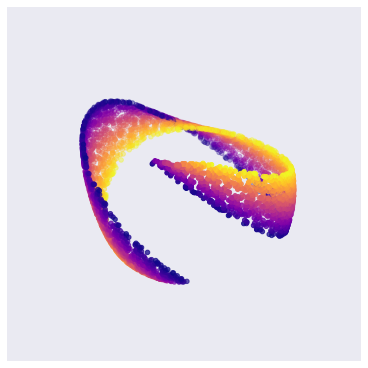

In [18]:
from ssapp.visualization.PCA_Visualisation import plot3DPCA
dataset = load_serialized_dataset('CircularHornDataset1')
plot3DPCA(dataset=dataset,param = 1,figsize=(5,5))
plt.axis('off')
plt.rcParams['figure.constrained_layout.use'] = True
plt.margins(0.01)
figSaver.save('FrontPage')

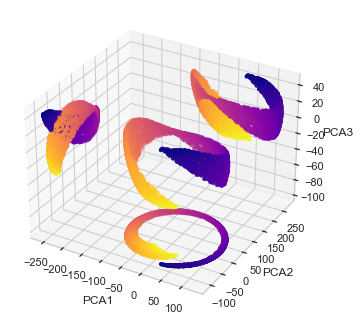

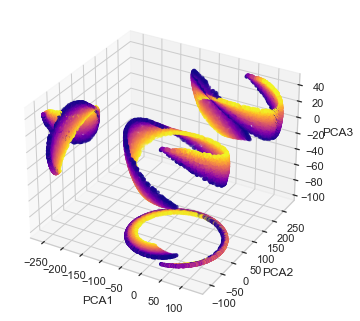

In [25]:
from ssapp.visualization.PCA_Visualisation import plot3DContour
from ssapp.data.AntennaDatasetLoaders import load_serialized_dataset
dataset = load_serialized_dataset('CircularHornDataset1')
plot3DContour(dataset,param=0,pca_components=(1,2,3),figsize = (4.5,4.5))

figSaver.save('CHA_3D_PCA_Param1')
plot3DContour(dataset,param=1,pca_components=(1,2,3),figsize = (4.5,4.5))
figSaver.save('CHA_3D_PCA_Param2')

In [ ]:
from ssapp.visualization.PCA_Visualisation import plot3DContour
from ssapp.data.AntennaDatasetLoaders import load_serialized_dataset
dataset = load_serialized_dataset('PatchAntennaDataset2')

plot3DContour(dataset,param=0,pca_components=(1,2,3))
figSaver.save('PatchAntenna_3D_PCA_Param1')
plot3DContour(dataset,param=1,pca_components=(1,2,3))
figSaver.save('PatchAntenna_3D_PCA_Param2')
plot3DContour(dataset,param=2,pca_components=(1,2,3))
figSaver.save('PatchAntenna_3D_PCA_Param3')

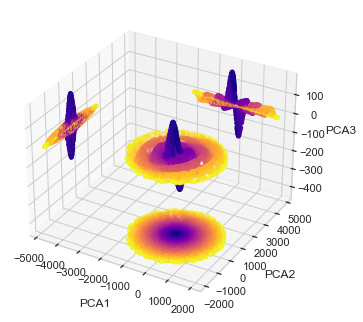

In [39]:
from ssapp.visualization.PCA_Visualisation import plot3DContour
from ssapp.data.AntennaDatasetLoaders import load_serialized_dataset
dataset = load_serialized_dataset('RFLCT')

plot3DContour(dataset,param=1,pca_components=(1,2,3),figsize=(4.5,4.5))
figSaver.save('ReflectorCut_3D_PCA_Param1')